<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Pipeline Tutorial](Introduction.ipynb) › Lesson 13: Using Pipeline with Alphalens
***

# Using Pipeline with Alphalens

Once you have a pipeline, there are two main things you can do with it:

1. Feed the pipeline results to Alphalens to analyze whether your factors are predictive of forward returns;
2. Use the pipeline in a Zipline strategy for the purpose of universe selection and/or trading signal generation. 

Analyzing your pipeline output with Alphalens makes sense if your pipeline includes factors that might be predictive of forward returns; it doesn't make sense if you are only using your pipeline for universe selection.

In this notebook, we will create a pipeline with a moving average factor for the `TradableStocksUS` universe, then use Alphalens to analyze whether the factor is predictive.

In [1]:
from zipline.pipeline import Pipeline, EquityPricing, master
from zipline.pipeline.factors import SimpleMovingAverage
# import our TradableStocksUS function
from codeload.pipeline_tutorial.tradable_stocks import TradableStocksUS

Let's create a factor that measures the percent difference between the 10-day and 30-day moving averages (close price). In other words, we are computing the degree to which the 10-day moving average is above the 30-day moving average.

As an added benefit, we will include each stock's sector in our pipeline output, which will allow us to view some additional Alphalens plots breaking down the factor's performance by sector.

In [2]:
def make_pipeline():
    
    universe = TradableStocksUS()
    
    # 10-day close price average.
    mean_10 = SimpleMovingAverage(inputs=EquityPricing.close, window_length=10, mask=universe)

    # 30-day close price average.
    mean_30 = SimpleMovingAverage(inputs=EquityPricing.close, window_length=30, mask=universe)

    # Percent difference factor.
    percent_difference = (mean_10 - mean_30) / mean_30
        
    return Pipeline(
        columns={
            'percent_difference': percent_difference,
            'sector': master.SecuritiesMaster.usstock_Sector.latest
        },
        screen=universe
    )

Instead of executing the pipeline with `run_pipeline`, we pass the pipeline to the Alphalens `from_pipeline` function. This function executes the pipeline, splits the data into quantiles based on a specified column in the pipeline output (in this example, the `percent_difference` column), and plots the relative forward performance of each quantile. In this example we analyze returns for the next day, next week (5 trading days), and next month (approx. 21 trading days), using the `periods` argument. We also use the `groupby` argument to tell Alphalens to group by the `sector` column in the pipeline output, which provides additional plots showing performance by sector.  

In the resulting tear sheet, the "Mean Relative Return By Factor Quantile" plot reveals that forward returns generally increase from quantiles 1 to 5. Intuitively, this tells us that stocks tend to perform better when their 10-day moving average is above their 30-day moving average.

,min,max,mean,std,count,avg daily count,count %
Factor Quantile,,,,,,,
1,-0.083,0.029,-0.026,0.020,506,2.0,28.6%
2,-0.050,0.038,-0.006,0.016,253,1.0,14.3%
3,-0.043,0.042,-0.000,0.017,253,1.0,14.3%
4,-0.041,0.045,0.007,0.017,253,1.0,14.3%
5,-0.035,0.101,0.024,0.025,506,2.0,28.6%


,1D,5D,21D
Ann. alpha,0.115,0.111,0.005
beta,-0.068,-0.076,0.163
Mean Relative Return Top Quantile (bps),5.815,4.761,2.527
Mean Relative Return Bottom Quantile (bps),-10.708,-7.685,1.925
Mean Spread (bps),16.523,12.500,0.799


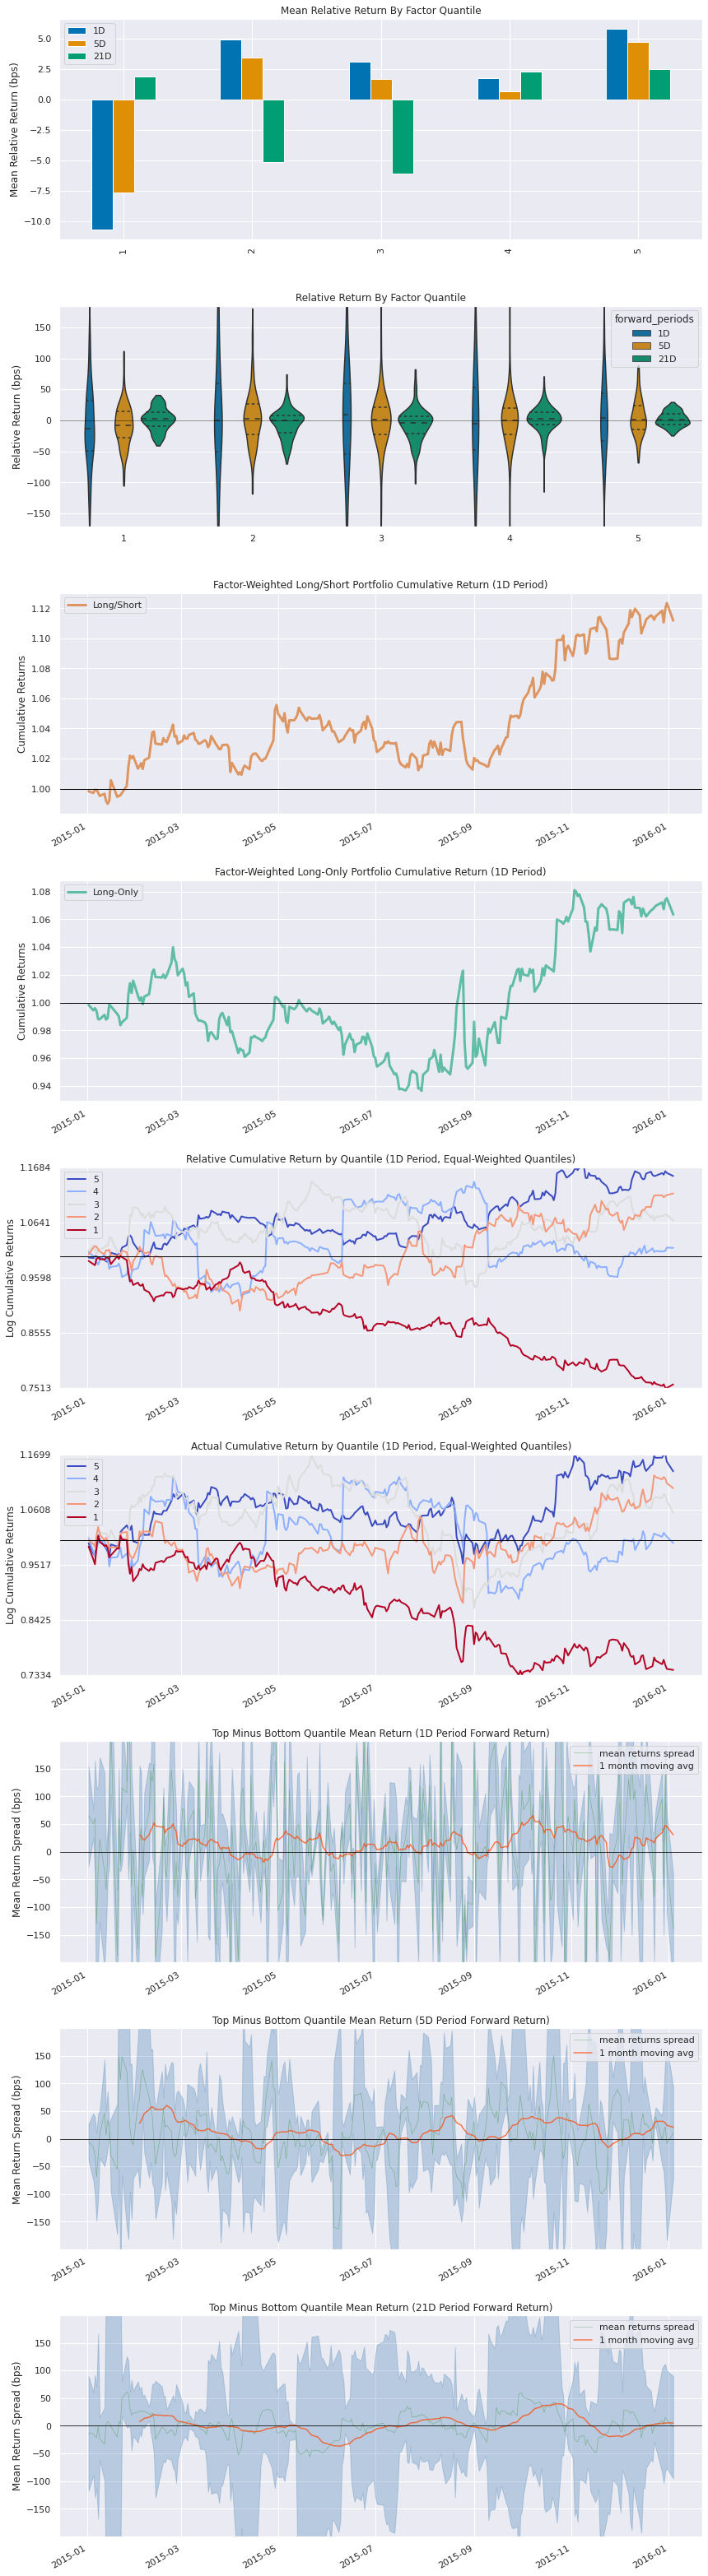

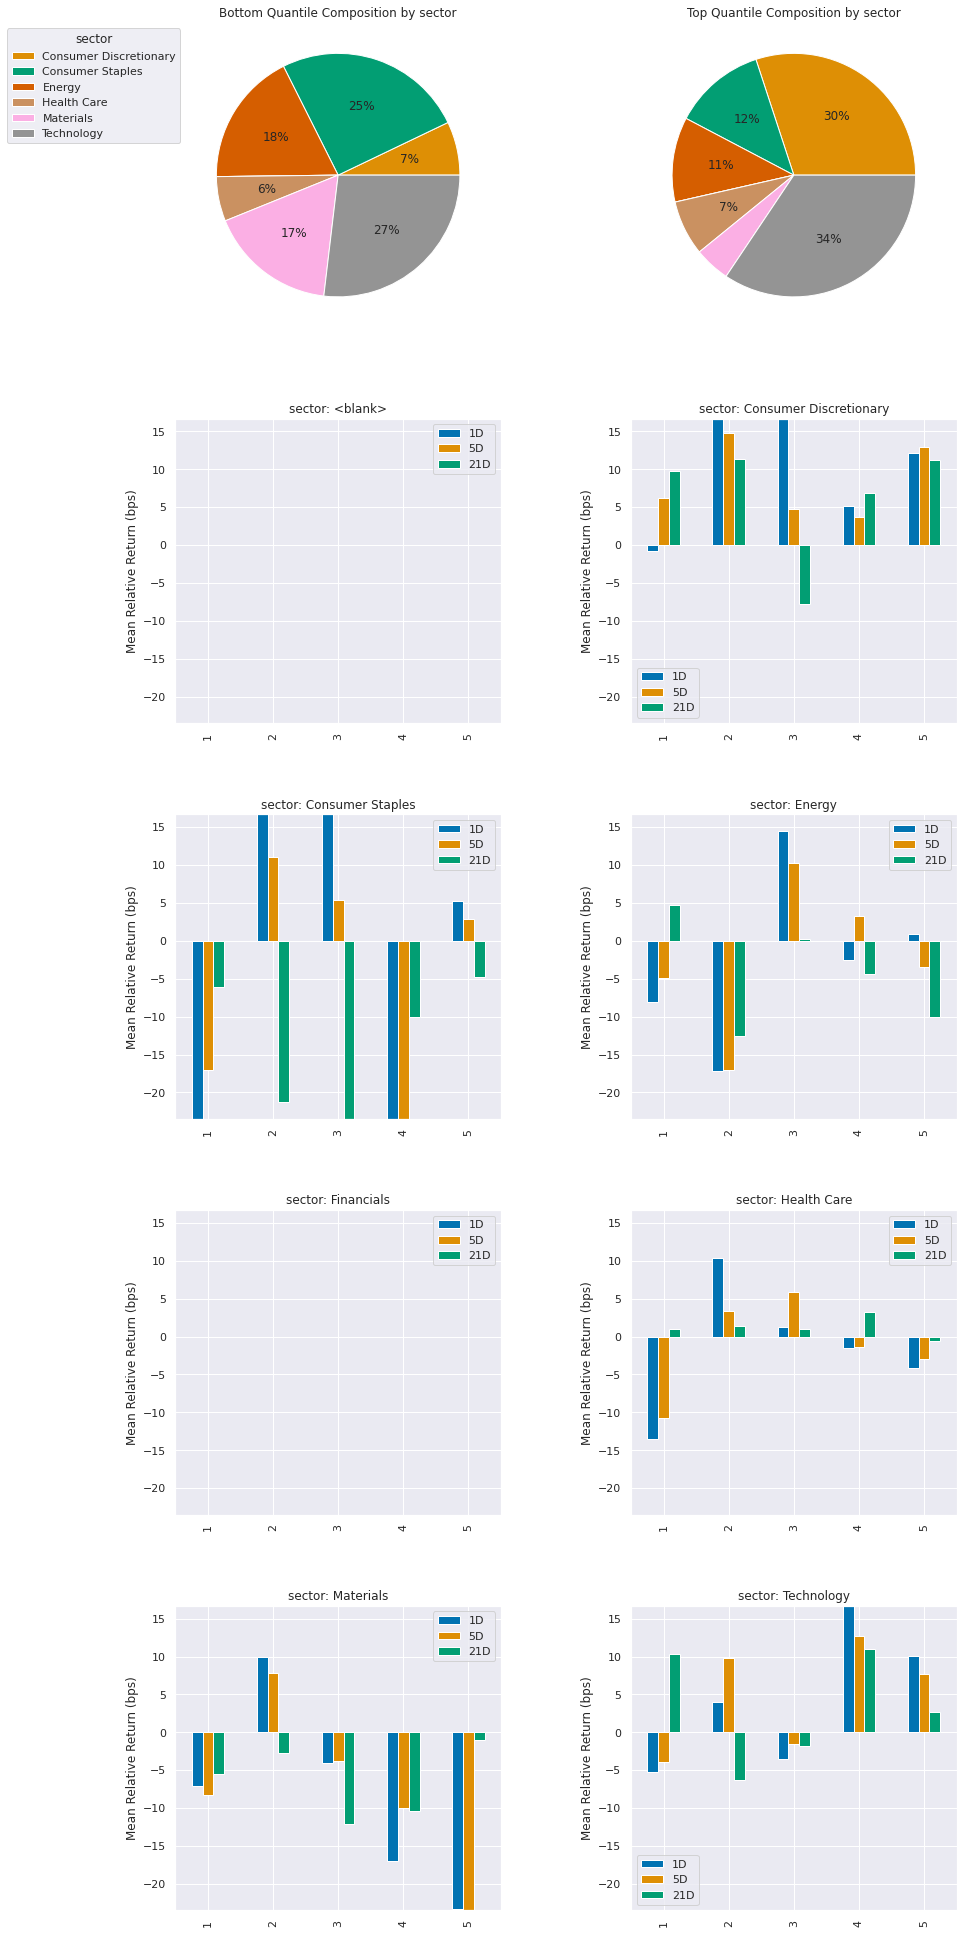

,1D,5D,21D
IC Mean,0.050,0.065,0.002
IC Std.,0.423,0.404,0.362
Risk-Adjusted IC,0.118,0.161,0.005
t-stat(IC),1.873,2.560,0.081
p-value(IC),0.062,0.011,0.936
IC Skew,-0.079,0.061,-0.091
IC Kurtosis,-0.573,-0.558,-0.275


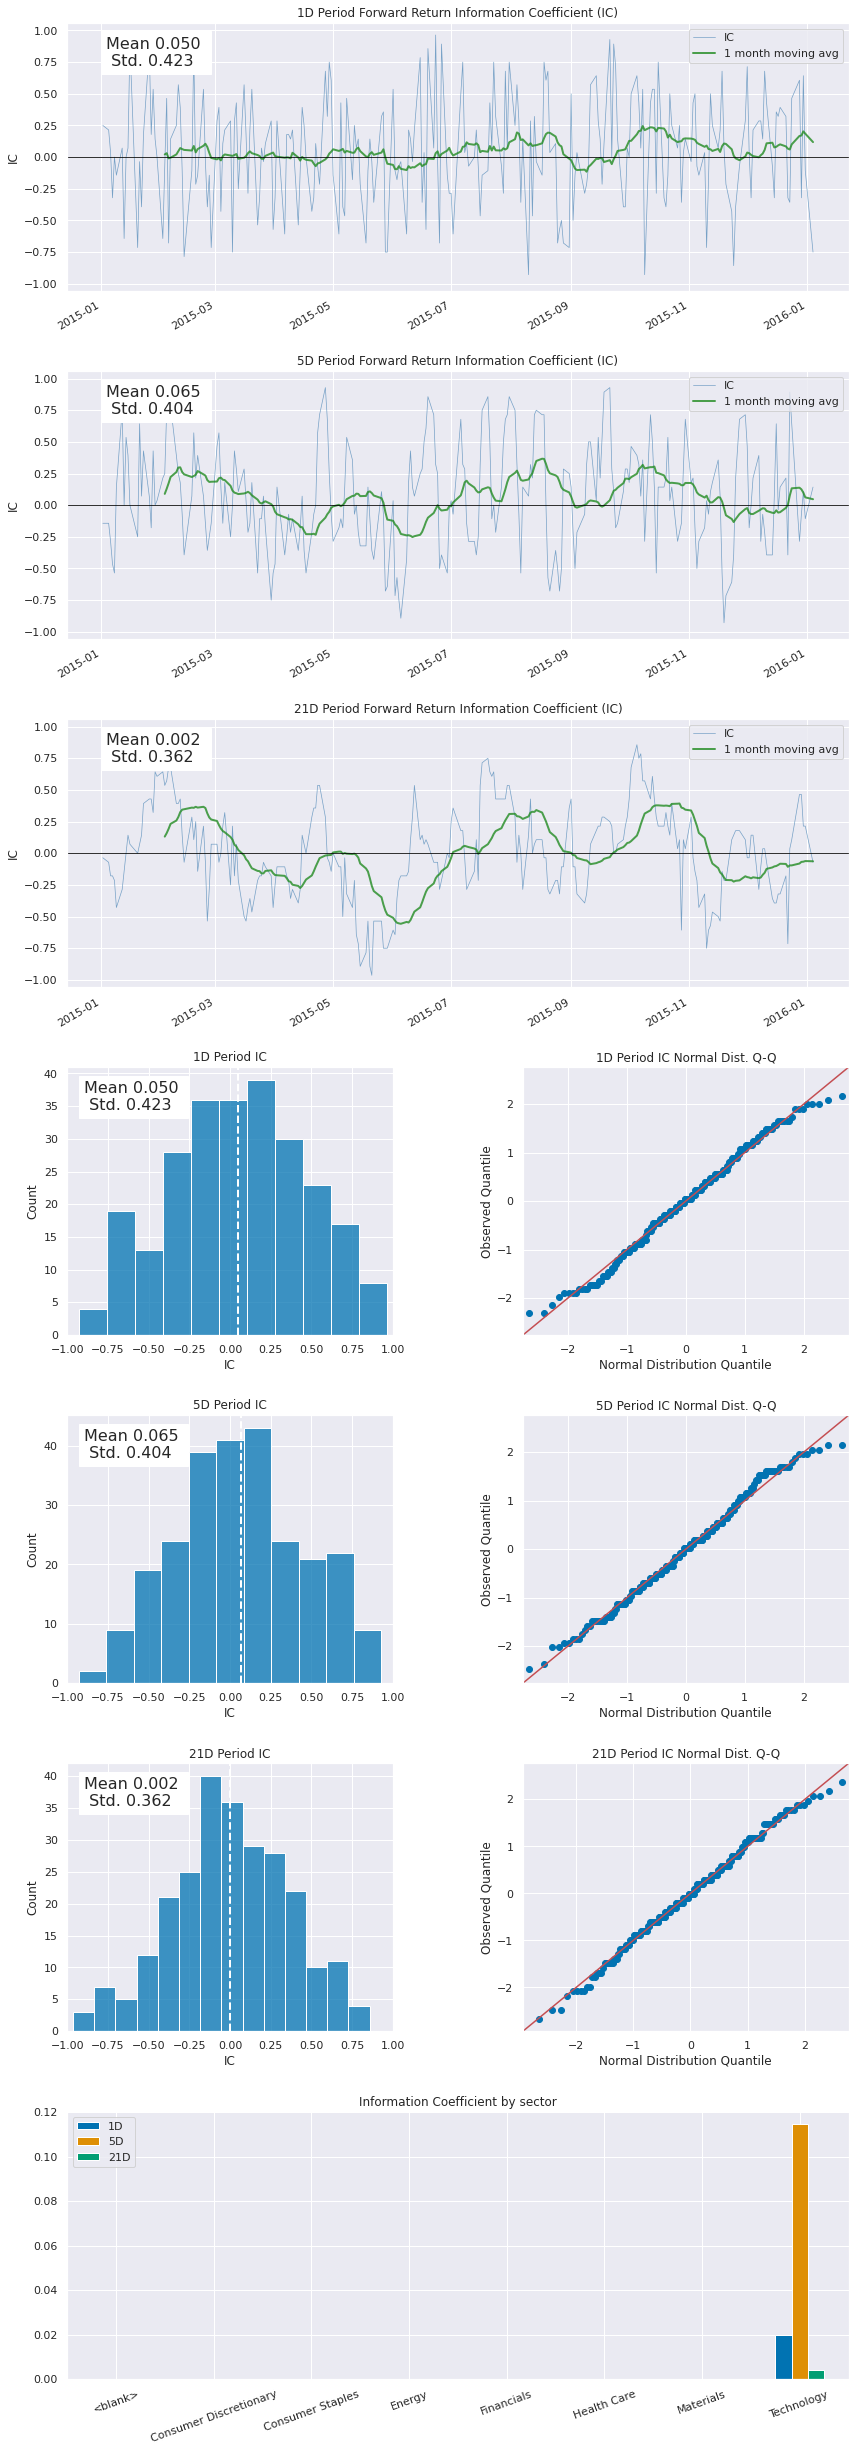

,1D,5D,21D
Quantile 1 Mean Turnover,0.060,0.230,0.700
Quantile 2 Mean Turnover,0.274,0.661,0.953
Quantile 3 Mean Turnover,0.262,0.621,0.780
Quantile 4 Mean Turnover,0.242,0.645,0.832
Quantile 5 Mean Turnover,0.065,0.262,0.685


,1D,5D,21D
Mean Factor Rank Autocorrelation,0.968,0.783,0.072


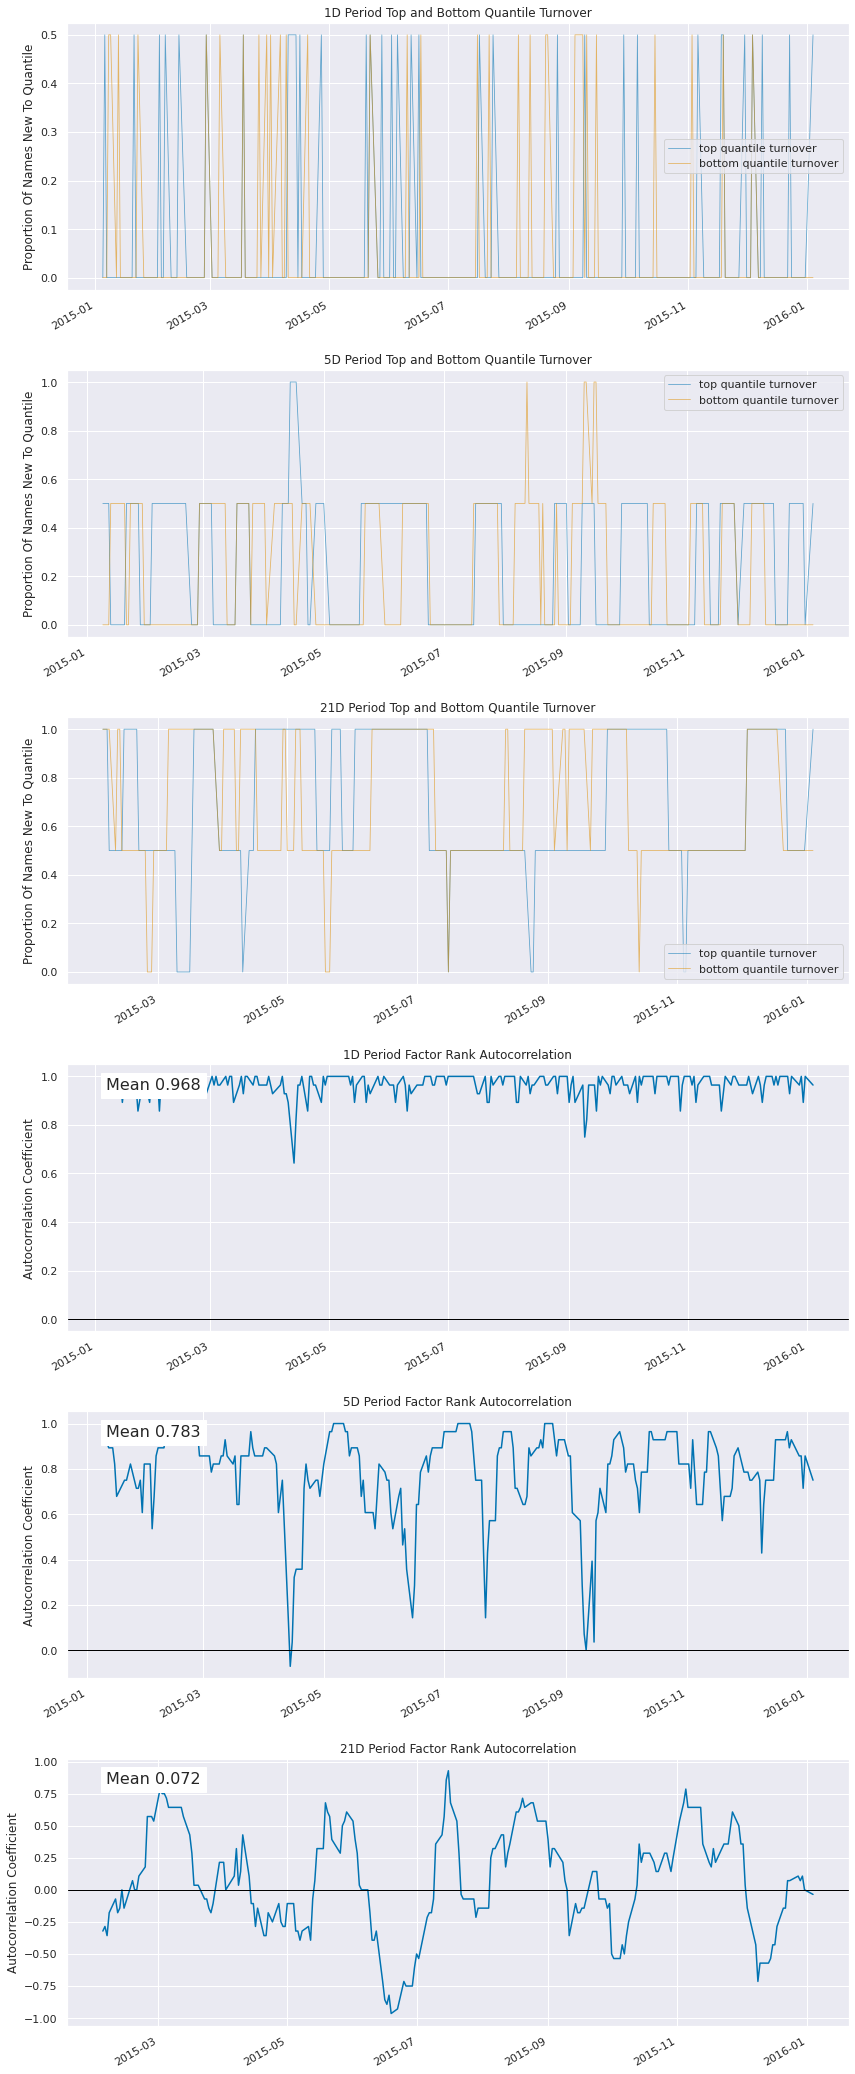

In [3]:
import alphalens as al

al.from_pipeline(
    make_pipeline(), 
    start_date='2015-01-01', 
    end_date='2016-01-01',
    factor="percent_difference",
    # analyze forward returns for the next day, next week, and next month
    periods=[1,5,21],
    groupby="sector"
)

For more information on interpreting an Alphalens tear sheet, please see Lecture 38 of the [Quant Finance Lecture series](https://www.quantrocket.com/code/?repo=quant-finance-lectures) in the Code Library.

---
[Back to Introduction](Introduction.ipynb) 